In [1]:
import pandas as pd
from numpy import mean
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_validate
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Let's load the recent and the old set

recent_set = pd.read_csv('crime_historic_recent.csv')
recent_full = pd.read_csv('crime_historic_full.csv')

### What is the major category crime distribution? 

We will examine the recent set for that, since the full version only should add more occurencies from previous months

In [3]:
crimes_dist = recent_set['Major Category'].value_counts()
crimes_dist

Vehicle Offences                        15923
Theft                                   15819
Miscellaneous Crimes Against Society    12983
Public Order Offences                   12654
Violence Against the Person              9908
Burglary                                 8901
Drug Offences                            7625
Arson and Criminal Damage                6907
Possession of Weapons                    6758
Robbery                                  6458
Name: Major Category, dtype: int64

## Note:

These are not the absolute occurencies per major crime category, rather than each crime taken down per LSOA Code region.

Let's see a chart and visualize a bit better.

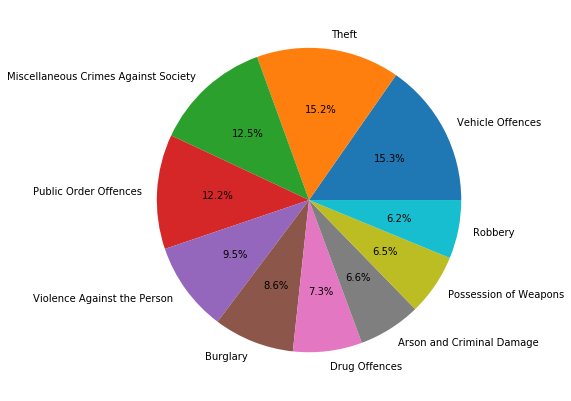

In [4]:
plt.figure(figsize=(8,7))
plt.pie(crimes_dist.values, labels=crimes_dist.keys(), autopct='%1.1f%%') 
plt.show()

## Major Category choice

#### We will pick the Robbery major category to examine and predict

The reason is because it's the smallest dataset and therefore we can run models faster for now on solo computer. 

In [5]:
# Pick our major category for this notebook

selected_category = 'Robbery'

In [6]:
# first filter by robbery the recent_set
recent_set = recent_set[recent_set['Major Category'] == selected_category]

# remove the non-numeric categories that are irrelevant to us for now, and the december of 2020, that is a future date
recent_set.drop(columns=['Major Category', 'Borough', 'Minor Category', '202012'], inplace=True)

# finally group by LSOA code and sum the values in columns
recent_set_groupped = recent_set.groupby('LSOA Code').sum()

# follow the same procedure with the full 10 year set
recent_full = recent_full[recent_full['Major Category'] == selected_category]
recent_full.drop(columns=['Major Category', 'Borough', 'Minor Category'], inplace=True)
recent_full_groupped = recent_full.groupby('LSOA Code').sum()

# merge on LSOA Code key
final_df = pd.merge(recent_set_groupped, recent_full_groupped, on='LSOA Code')

final_df.head(10)

,201901,201902,201903,201904,201905,201906,201907,201908,201909,201910,...,201803,201804,201805,201806,201807,201808,201809,201810,201811,201812
LSOA Code,,,,,,,,,,,,,,,,,,,,,
E01000006,2,0,0,3,1,1,1,0,0,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
E01000007,2,4,4,5,3,4,9,7,5,11,...,2.0,1.0,1.0,3.0,1.0,0.0,5.0,0.0,3.0,4.0
E01000008,0,0,0,0,0,1,1,1,2,2,...,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0
E01000009,4,1,3,0,4,4,3,2,5,2,...,0.0,0.0,0.0,0.0,2.0,1.0,2.0,2.0,2.0,2.0
E01000010,10,7,3,13,9,4,9,8,8,11,...,3.0,2.0,3.0,9.0,15.0,12.0,10.0,12.0,14.0,5.0
E01000011,0,1,0,0,1,2,0,0,0,1,...,3.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
E01000012,0,0,0,0,1,1,0,0,0,1,...,1.0,0.0,2.0,1.0,1.0,2.0,1.0,2.0,0.0,0.0
E01000013,0,4,3,2,2,5,3,0,1,1,...,0.0,7.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,2.0
E01000014,0,0,0,0,3,0,0,0,0,3,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0


### Change types in some columns

The full set, the one that contains data for past crimes, way beyond last 24 months, it appears thawt holds it's values into
types of floats. These have to be converted into integers. Let's do it now.

In [7]:
raw_set = final_df.astype('int32')
raw_set.head(5)

,201901,201902,201903,201904,201905,201906,201907,201908,201909,201910,...,201803,201804,201805,201806,201807,201808,201809,201810,201811,201812
LSOA Code,,,,,,,,,,,,,,,,,,,,,
E01000006,2,0,0,3,1,1,1,0,0,0,...,1,0,0,0,0,0,0,1,1,1
E01000007,2,4,4,5,3,4,9,7,5,11,...,2,1,1,3,1,0,5,0,3,4
E01000008,0,0,0,0,0,1,1,1,2,2,...,1,1,1,1,0,0,0,0,0,3
E01000009,4,1,3,0,4,4,3,2,5,2,...,0,0,0,0,2,1,2,2,2,2
E01000010,10,7,3,13,9,4,9,8,8,11,...,3,2,3,9,15,12,10,12,14,5


### Exploratory analysis

We will try to examine if the given crime, we are investigating is more likely to occur under a specific month. This should be extremely important, since we are trying to predict how many robberies will occur in one-month period.

In [8]:
months_cols = [date[4:] for date in raw_set.columns]
months_frame = raw_set.copy()
months_frame.columns = months_cols

months_frame = months_frame.groupby(axis=1, level=0).sum()
sums_per_month = [months_frame[x].sum() for x in months_frame.columns]

months_frame.head(5)

,01,02,03,04,05,06,07,08,09,10,11,12
LSOA Code,,,,,,,,,,,,
E01000006,9,5,6,7,3,3,4,5,6,7,6,9
E01000007,38,31,23,21,19,22,36,33,29,26,19,26
E01000008,10,8,8,10,7,7,6,5,3,11,6,15
E01000009,26,17,26,18,20,29,26,20,25,23,25,27
E01000010,62,53,49,41,66,53,72,68,60,55,46,42


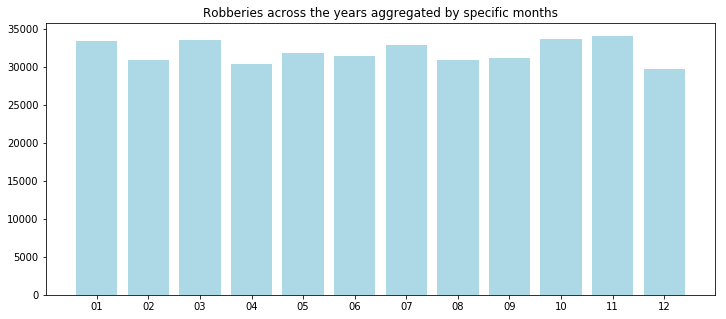

In [9]:
# Let's have some support vector machine champs comparison!

fig = (12, 5)

plt.figure(figsize= fig)
plt.title('Robberies across the years aggregated by specific months')
plt.bar(months_frame.columns, sums_per_month, color='lightblue')

plt.show()

As it seems there is no significant difference between aggregated months, with the exception of december, but take note that 
we excluded december from the last year. 

So at least for that given major category of  **robbery** month doesn't seem to play vital role at a first glance.

### Let's try and do some exploratory analysis for each year

Let's see if there is a significant increase or decline throught the years from 2008 until now.

In [10]:
years_cols = [date[0:4] for date in raw_set.columns]
years_frame = raw_set.copy()
years_frame.columns = years_cols

years_frame = years_frame.groupby(axis=1, level=0).sum()
sums_per_year = [years_frame[x].sum() for x in years_frame.columns]

years_frame.head(5)

,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
LSOA Code,,,,,,,,,,,,,
E01000006,6,6,10,10,5,2,3,3,4,3,5,11,2
E01000007,18,37,22,25,18,15,10,5,22,31,28,58,34
E01000008,12,12,10,11,2,7,2,6,5,8,9,7,5
E01000009,32,28,36,29,20,17,15,18,12,14,13,31,17
E01000010,41,42,49,42,40,30,21,33,43,60,95,93,78


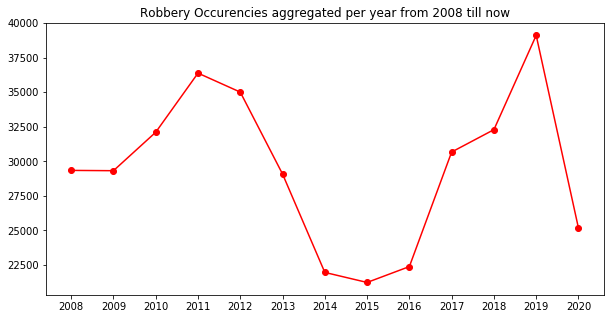

In [11]:
plt.figure(figsize=(10, 5))
plt.title('Robbery Occurencies aggregated per year from 2008 till now')
plt.plot(years_frame.columns, sums_per_year, color='red', marker='o')

plt.show()

### Quick Note:

Although each month individually doesn't seem to produce a significant influence to robberies, the same cannot be told about
each individual year. Especially for the trilogy 2014-2016 that didn't produce the same amount of robberies as elsewhere.

In [12]:
# The current block is all about converting target column of november 2020, into a set of possible strings

# What is the max robberies value for a given LSOA for november 2020?
max_robberies = raw_set['202011'].max()

# If a given value in november 2020 falls between min and max value, the new value will be the corresponding text
transform_map = [
    {'min_value': 0, 'max_value': 1, 'replace_text': 'low crime'},
    {'min_value': 2, 'max_value': 5, 'replace_text': 'medium crime'},
    {'min_value': 6, 'max_value': 10, 'replace_text': 'high crime'},
    {'min_value': 10, 'max_value': max_robberies, 'replace_text': 'very high crime'}
]



def convert_to_text(num_of_crimes, data_map):
    '''
    function to convert each individual occurences robberies in november 2020
    into a string, this will give back 4 possible classes
    '''
    for item in data_map:
        if num_of_crimes >= item['min_value'] and num_of_crimes <= item['max_value']:
            return item['replace_text']

# replace november 2020 values with the strng classes
raw_set['202011'] = raw_set['202011'].apply(lambda crime_val: convert_to_text(crime_val, transform_map))

In [13]:
# save target columns for quicker reference
target = raw_set['202011']

# remove target so we don't include it in our future models
X_raw = raw_set.drop(columns='202011')

X_raw.head(5)

,201901,201902,201903,201904,201905,201906,201907,201908,201909,201910,...,201803,201804,201805,201806,201807,201808,201809,201810,201811,201812
LSOA Code,,,,,,,,,,,,,,,,,,,,,
E01000006,2,0,0,3,1,1,1,0,0,0,...,1,0,0,0,0,0,0,1,1,1
E01000007,2,4,4,5,3,4,9,7,5,11,...,2,1,1,3,1,0,5,0,3,4
E01000008,0,0,0,0,0,1,1,1,2,2,...,1,1,1,1,0,0,0,0,0,3
E01000009,4,1,3,0,4,4,3,2,5,2,...,0,0,0,0,2,1,2,2,2,2
E01000010,10,7,3,13,9,4,9,8,8,11,...,3,2,3,9,15,12,10,12,14,5


In [14]:
# Let's see the target if converted correctly

target[0:10]

LSOA Code
E01000006       low crime
E01000007    medium crime
E01000008       low crime
E01000009       low crime
E01000010    medium crime
E01000011       low crime
E01000012    medium crime
E01000013    medium crime
E01000014       low crime
E01000015    medium crime
Name: 202011, dtype: object

In [15]:
# scale data using minmax scaler, this is more like building a good habit, since all values are on the same scale regardless

min_max_scaler = MinMaxScaler()
scaled_X = min_max_scaler.fit_transform(X_raw)
scaled_df = pd.DataFrame(scaled_X, columns=X_raw.columns)

scaled_df.head(5)

,201901,201902,201903,201904,201905,201906,201907,201908,201909,201910,...,201803,201804,201805,201806,201807,201808,201809,201810,201811,201812
0,0.041667,0.000000,0.000000,0.055556,0.020408,0.021739,0.021277,0.000000,0.000000,0.00,...,0.035714,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.020833,0.016393,0.014286
1,0.041667,0.081633,0.068966,0.092593,0.061224,0.086957,0.191489,0.142857,0.102041,0.22,...,0.071429,0.04,0.021277,0.107143,0.027778,0.000000,0.113636,0.000000,0.049180,0.057143
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.021739,0.021277,0.020408,0.040816,0.04,...,0.035714,0.04,0.021277,0.035714,0.000000,0.000000,0.000000,0.000000,0.000000,0.042857
3,0.083333,0.020408,0.051724,0.000000,0.081633,0.086957,0.063830,0.040816,0.102041,0.04,...,0.000000,0.00,0.000000,0.000000,0.055556,0.034483,0.045455,0.041667,0.032787,0.028571
4,0.208333,0.142857,0.051724,0.240741,0.183673,0.086957,0.191489,0.163265,0.163265,0.22,...,0.107143,0.08,0.063830,0.321429,0.416667,0.413793,0.227273,0.250000,0.229508,0.071429


### How are our classes distributed?

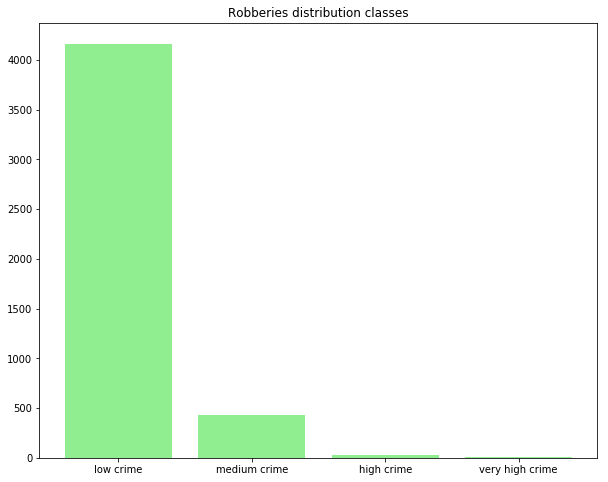

In [16]:
plt.figure(figsize= (10, 8))
plt.title('Robberies distribution classes')
plt.bar(target.value_counts().keys(), target.value_counts().values, color='lightgreen')

plt.show()

## Imbalanced Data,

As the graph above suggest, not only we are dealing with a multinomial classification problem, but the necessary classes that
we have to predict are heavily imbalanced. 

The question is if we can predict accurately future crime scenes, just by looking in the past. That being said we havn't sufficient evidencethat specific classes are more important to predict than others. 

### Metric Decision

For that reason we will pick pure **accuracy score** for our metric and source of truth.

Although one could argue that predicting **high crime** and **very high crime** areas, this has to be discussed and cleared with the stakeholders. In such case we would have to choose something more close to an **f2 score** for these two classes.

### Strategy and models

Since we are dealing with such heavy imbalanced dataset and classes, there are couple of ways to try and balance our dataset.

1. Import a SMOTE technique, try to syntheticall increase the size of the minority classes, and at the same time maybe undersample majority classes. 
2. Adjust class weights on machine learning models, in order to have high accuracy not only because low crime and medium crime appear dominantly more often, but also by taking under consideration that high and very high crime scenes are more important.

**We will choose the second strategy**, that is why all the models and algorithms that follow are the ones that give us the opportunity to **adjust class weights** (therefore no SVM's nor KNN's).

In [17]:
# generic function, we pass the model as first param, X_features and target column. Applies 4 Fold Cross Validation with metrics
# accuracy. After each run prints the average of these metric (mean of 4 folds), and returns the score. 

def run_model(model, feature_set, target_label):
    cross_score = cross_validate(model, feature_set, target_label, scoring = 'accuracy', cv = 4)
    mean_accuracy = round(mean(cross_score['test_score']), 3)
    print('The model has average accuracy {}'.format(mean_accuracy))
    return mean_accuracy

In [18]:
# Let's start with logistic regression, first try, balanced class weight will adjust weights inversely proportinal to their frequency

lg_model = LogisticRegression(random_state=101, max_iter=300, solver='newton-cg', class_weight='balanced', multi_class='multinomial')
run_model(lg_model, X_raw, target)

The model has average accuracy 0.755


0.755

In [19]:
# Let's put some arbitrary values for the weights of the class

class_weights = {
    'low crime': 0.05,
    'medium crime': 0.1,
    'high crime': 0.35,
    'very high crime': 0.5
}

lg_model = LogisticRegression(random_state=101, max_iter=300, solver='newton-cg', class_weight=class_weights, multi_class='multinomial')
run_model(lg_model, X_raw, target)

The model has average accuracy 0.885


0.885

In [20]:
# ok that was better let's use these weights with the scaled dataframe

lg_model = LogisticRegression(random_state=101, max_iter=300, solver='newton-cg', class_weight=class_weights, multi_class='multinomial')
run_model(lg_model, scaled_df, target)

The model has average accuracy 0.901


0.901

### Quick notes on logistic regression 

Not quite sure how is this possible and the same logistic regression model (remember same random state number) worked better with the scaled version of X's. Logistic regression supposedly add specific weights and this is it's core procedure (weight's are adjusted and each coefficient fullfills the maximum likelihood estimation for fitting the current data).

We will have to keep an eye on this one for the future, for now is a mystery, but this is our **logistic regression champ** for now ironically.

In [21]:
# applying grid search for random forest, This could take a while. Feel free to skip, you can find the results on later blocks

grid_search_forest = GridSearchCV(
    estimator = RandomForestClassifier(random_state=101),
    param_grid = {
        'n_estimators': [300, 500],
        'max_depth': [3, 5, 8, 10],
        'criterion': ['gini', 'entropy']
    },
    scoring = 'accuracy',
    cv = 4
)

grid_result = grid_search_forest.fit(X_raw, target)
grid_result.best_params_

{'criterion': 'gini', 'max_depth': 10, 'n_estimators': 500}

In [22]:
rfc_model = RandomForestClassifier(random_state=101, class_weight='balanced', criterion='gini', max_depth=10, n_estimators=500)
run_model(rfc_model, X_raw, target)

The model has average accuracy 0.901


0.901

In [23]:
# We use again the arbitrary class_weight that simulate the frequency each class appears inversely proportionally

rfc_model = RandomForestClassifier(random_state=101, class_weight=class_weights, criterion='gini', max_depth=10, n_estimators=500)
run_model(rfc_model, X_raw, target)

The model has average accuracy 0.902


0.902

## End notes:

We adjusted the weights and the importance of the classes so we get a better estimation of the accuracy metric. We did that, in order to avoid predicting all classes as **low crime** and still getting **90%** accuracy.

Now the current accuracy score is closer to the truth, even if we deal with a more evenly distributed data. Both random forest and logistic regression gave similar results and a general good predictive score on what the outcome robberies per LSOA for a futuristic month could be